In [1]:
import glob
import os
import json

from icecream import ic
import numpy as np
from mmcv import Config
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm  # Progress bar

from functions import create_train_validation_and_test_scene_list, get_model, get_loss, load_model
from loaders import get_variable_options, AI4ArcticChallengeTestDataset, AI4ArcticChallengeDataset

torch.set_num_threads(10)

/data1/antonk/miniconda/envs/mm_seaice/lib/python3.12/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/data1/antonk/miniconda/envs/mm_seaice/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
args_config = 'configs/sir_is2/sir_is2_04b.py'
ic(args_config)
cfg = Config.fromfile(args_config)
train_options = cfg.train_options
# Get options for variables, amsrenv grid, cropping and upsampling.
train_options = get_variable_options(train_options)
create_train_validation_and_test_scene_list(train_options)
device = 'cpu'
net = get_model(train_options, device)
net


ic| args_config: 'configs/sir_is2/sir_is2_04b.py'


Options train_list and validate_list initialised


UNet_regression_SIR_IS2(
  (input_block): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (contract_blocks): ModuleList(
    (0): ContractingBlock(
      (contract_block): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (double_conv): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1)

In [ ]:
epoch = load_model(net, 'sir_is2_04/best_model_sir_is2_04_00197.pth', device='cpu')

In [3]:
dataset = AI4ArcticChallengeDataset(files=train_options['train_list'][:3], options=train_options, do_transform=True)

100%|██████████| 3/3 [00:06<00:00,  2.04s/it]


sir_4000ms_seg


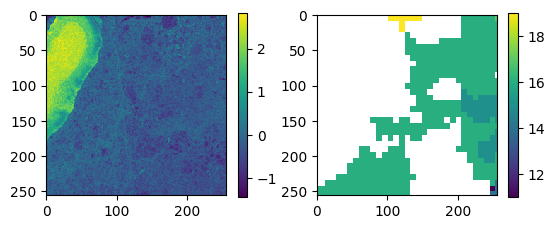

sir_4000ms_reg


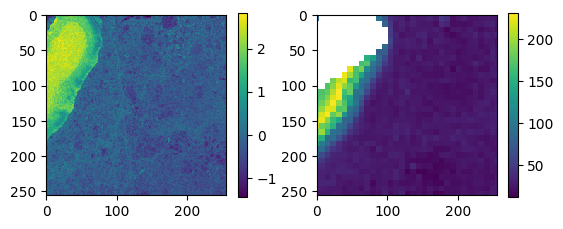

In [8]:
x, y = dataset[0]
for name in y:
    hh = np.ma.masked_where(x[0][0] == 255, x[0][0])
    sir1 = np.ma.masked_where(y[name][0] == 255, y[name][0])
    print(name)
    fig, axs = plt.subplots(1, 2)
    imsh0 = axs[0].imshow(hh, interpolation='nearest')
    imsh1 = axs[1].imshow(sir1, interpolation='nearest')
    plt.colorbar(imsh0, ax=axs[0], shrink=0.5)
    plt.colorbar(imsh1, ax=axs[1], shrink=0.5)
    plt.show()


In [10]:
dataset_val = AI4ArcticChallengeTestDataset(options=train_options, files=train_options['validate_list'][:3], mode='train')
x, y, cfv_masks, tfv_mask, name, original_size = dataset_val[0]
print(x.shape, y['sir_4000ms_reg'].shape, cfv_masks['sir_4000ms_reg'].shape, tfv_mask.shape, name, original_size)


100%|██████████| 2/2 [00:03<00:00,  1.65s/it]

torch.Size([1, 6, 2768, 2587]) (2768, 2587) (2768, 2587) torch.Size([2768, 2587]) S1A_EW_GRDM_1SDH_20200102T164018_20200102T164125_030624_038243_989E.nc.npz (5537, 5174)


In [11]:
dataloader_train = torch.utils.data.DataLoader(
        dataset, batch_size=None, shuffle=True, num_workers=train_options['num_workers'], pin_memory=True)
dataloader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=None, num_workers=train_options['num_workers_val'], shuffle=False)
loss_ce_functions = {chart: get_loss(train_options['chart_loss'][chart]['type'], chart=chart, **train_options['chart_loss'][chart])
                         for chart in train_options['charts']}



In [12]:
# Loops though batches in queue.
for i, (batch_x, batch_y) in enumerate(tqdm(iterable=dataloader_train, total=train_options['epoch_len'],
                                            colour='red')):
    # torch.cuda.empty_cache()  # Empties the GPU cache freeing up memory.
    train_loss_batch = torch.tensor([0.]).to(device)  # Reset from previous batch.
    #edge_consistency_loss = torch.tensor([0.]).to(device)
    cross_entropy_loss = torch.tensor([0.]).to(device)
    # - Transfer to device.
    batch_x = batch_x.to(device, non_blocking=True)

    # - Forward pass.
    output = net(batch_x)
    break

  0%|          | 0/10 [00:01<?, ?it/s]


In [13]:
for chart, weight in zip(train_options['charts'], train_options['task_weights']):

    #if train_options['edge_consistency_loss'] != 0:
    #    edge_consistency_loss = loss_water_edge_consistency(output)

    if weight != 0:
        _loss = loss_ce_functions[chart](output[chart], batch_y[chart].to(device))
        print(chart, _loss)
        #if torch.isnan(_loss):
        #    import ipdb; ipdb.set_trace()
        #cross_entropy_loss += weight * _loss


sir_4000ms_seg tensor(1473.8978, grad_fn=<DivBackward0>)
sir_4000ms_reg tensor(2060.0461, grad_fn=<DivBackward0>)


In [26]:
from functions import class_decider, compute_metrics
val_loss_sum = torch.tensor([0.])  # To sum the validation batch losses during the epoch.
# To sum the validation cross entropy batch losses during the epoch.
val_cross_entropy_loss_sum = torch.tensor([0.])

outputs_flat = {chart: torch.Tensor().to(device) for chart in train_options['charts']}
inf_ys_flat = {chart: torch.Tensor().to(device) for chart in train_options['charts']}
# Outputs mask by train fill values
outputs_tfv_mask = {chart: torch.Tensor().to(device) for chart in train_options['charts']}
net.eval()  # Set network to evaluation mode.
print('Validating...')
# - Loops though scenes in queue.
for i, (inf_x, inf_y, cfv_masks, tfv_mask, name, original_size) in enumerate(tqdm(iterable=dataloader_val,
                                                                    total=len(train_options['validate_list']),
                                                                    colour='green')):
    torch.cuda.empty_cache()
    # Reset from previous batch.
    # train fill value mask
    # tfv_mask = (inf_x.squeeze()[0, :, :] == train_options['train_fill_value']).squeeze()
    val_loss_batch = torch.tensor([0.]).to(device)
    #val_edge_consistency_loss = torch.tensor([0.]).to(device)
    val_cross_entropy_loss = torch.tensor([0.]).to(device)
    # - Ensures that no gradients are calculated, which otherwise take up a lot of space on the GPU.
    with torch.no_grad(), torch.amp.autocast('cuda'):
        inf_x = inf_x.to(device, non_blocking=True)
        if train_options['model_selection'] == 'swin':
            output = slide_inference(inf_x, net, train_options, 'val')
            # output = batched_slide_inference(inf_x, net, train_options, 'val')
        else:
            output = net(inf_x)

        for chart, weight in zip(train_options['charts'], train_options['task_weights']):
            # SIR
            if 'SIR' in train_options['charts'][0]:
                val_cross_entropy_loss += weight * loss_ce_functions[chart](
                    output[chart][:,:,~cfv_masks[chart]],
                    inf_y[chart][~cfv_masks[chart]].unsqueeze(0).long().to(device)
                )
            else:
                # SIC, SOD, FLZ
                val_cross_entropy_loss += weight * loss_ce_functions[chart](
                    output[chart],
                    inf_y[chart].unsqueeze(0).long().to(device)
                )

        #if train_options['edge_consistency_loss'] != 0:
        #    a = train_options['edge_consistency_loss']
        #    val_edge_consistency_loss = a*loss_water_edge_consistency(output)

    val_loss_batch = val_cross_entropy_loss #+ val_edge_consistency_loss
    #raise
    # - Final output layer, and storing of non masked pixels.
    for chart in train_options['charts']:
        # TODO:
        # use class decider of output is classification, not regression
        #output[chart] = class_decider(output[chart], train_options, chart)
        outputs_flat[chart] = torch.cat((outputs_flat[chart], output[chart].squeeze()[~cfv_masks[chart].squeeze()]))
        inf_ys_flat[chart] = torch.cat((inf_ys_flat[chart], inf_y[chart][~cfv_masks[chart]].to(device, non_blocking=True)))
    # - Add batch loss.
    val_loss_sum += val_loss_batch.detach().item()
    val_cross_entropy_loss_sum += val_cross_entropy_loss.detach().item()

# - Average loss for displaying
val_loss_epoch = torch.true_divide(val_loss_sum, i + 1).detach().item()
val_cross_entropy_epoch = torch.true_divide(val_cross_entropy_loss_sum, i + 1).detach().item()
#val_edge_consistency_epoch = torch.true_divide(val_edge_consistency_loss_sum, i + 1).detach().item()

# - Compute the relevant scores.
print('Computing Metrics on Val dataset')
combined_score, scores = compute_metrics(true=inf_ys_flat, pred=outputs_flat, charts=train_options['charts'],
                                            metrics=train_options['chart_metric'], num_classes=train_options['n_classes'])


Validating...


  0%|          | 0/2 [00:00<?, ?it/s]/data1/antonk/miniconda/envs/mm_seaice/lib/python3.12/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 2/2 [00:19<00:00,  9.52s/it]

Computing Metrics on Val dataset


In [27]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
scores, combined_score, r2_score(inf_ys_flat['sir_4000ms_reg'], outputs_flat['sir_4000ms_reg']), pearsonr(inf_ys_flat['sir_4000ms_reg'].cpu().numpy(), outputs_flat['sir_4000ms_reg'].cpu().numpy())

({'sir_4000ms_seg': tensor(31.6560), 'sir_4000ms_reg': tensor(47.0830)},
 tensor(39.3700),
 0.4708307512420493,
 PearsonRResult(statistic=np.float64(0.6879440656753734), pvalue=np.float32(0.0)))

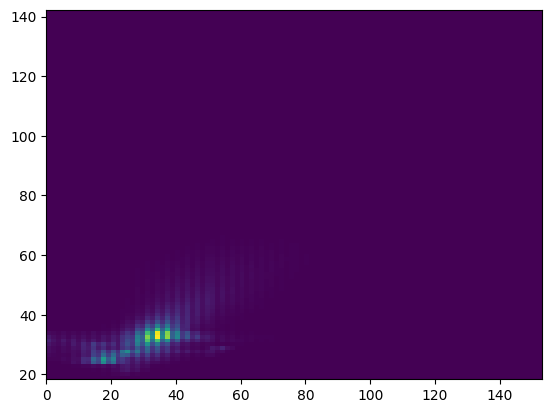

In [29]:
_ =plt.hist2d(inf_ys_flat['sir_4000ms_reg'], outputs_flat['sir_4000ms_reg'], 100)

In [ ]:
args_config = 'configs/sir/sir_01.py'
ic(args_config)
cfg = Config.fromfile(args_config)
train_options = cfg.train_options
# Get options for variables, amsrenv grid, cropping and upsampling.
train_options = get_variable_options(train_options)
create_train_validation_and_test_scene_list(train_options)
device = 'cpu'
net = get_model(train_options, device)
net


In [ ]:
dataset = AI4ArcticChallengeDataset(files=train_options['train_list'][:5], options=train_options, do_transform=True)
x, y = dataset[0]
for name in y:
    sir1 = np.ma.masked_where(y[name][0] == 255, y[name][0])
    print(name)
    plt.imshow(sir1, interpolation='nearest')
    plt.colorbar()
    plt.show()
    break

In [ ]:
dataset_val = AI4ArcticChallengeTestDataset(options=train_options, files=train_options['validate_list'][:3], mode='train')
x, y, cfv_masks, tfv_mask, name, original_size = dataset_val[0]
print(x.shape, y['sir_eqs0250'].shape, cfv_masks['sir_eqs0250'].shape, tfv_mask.shape, name, original_size)


In [ ]:
sod = np.ma.masked_where(y['sir_eqs0250'] == 255, y['sir_eqs0250'])
fig, axs = plt.subplots(1, 3)
axs[0].imshow(x[0, 0])
axs[1].imshow(x[0, 5])
imsh2 = axs[2].imshow(sod, interpolation='nearest')
plt.colorbar(imsh2, shrink=0.5)
plt.show()

In [ ]:
dataloader_train = torch.utils.data.DataLoader(
        dataset, batch_size=None, shuffle=True, num_workers=train_options['num_workers'], pin_memory=True)
dataloader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=None, num_workers=train_options['num_workers_val'], shuffle=False)
loss_ce_functions = {chart: get_loss(train_options['chart_loss'][chart]['type'], chart=chart, **train_options['chart_loss'][chart])
                         for chart in train_options['charts']}


In [ ]:
for i, (inf_x, inf_y, cfv_masks, tfv_mask, name, original_size) in enumerate(tqdm(iterable=dataloader_val,
                                                                    total=len(train_options['validate_list']),
                                                                    colour='green')):
    with torch.no_grad():
        inf_x = inf_x.to(device, non_blocking=True)
        output = net(inf_x)

        for chart, weight in zip(train_options['charts'], train_options['task_weights']):

            val_cross_entropy_loss = weight * loss_ce_functions[chart](
                output[chart][:,:,~cfv_masks[chart]],
                inf_y[chart][~cfv_masks[chart]].unsqueeze(0).long().to(device)
            )
            print(name, chart, val_cross_entropy_loss)
    break

In [ ]:
# Loops though batches in queue.
for i, (batch_x, batch_y) in enumerate(tqdm(iterable=dataloader_train, total=train_options['epoch_len'],
                                            colour='red')):
    # torch.cuda.empty_cache()  # Empties the GPU cache freeing up memory.
    train_loss_batch = torch.tensor([0.]).to(device)  # Reset from previous batch.
    #edge_consistency_loss = torch.tensor([0.]).to(device)
    cross_entropy_loss = torch.tensor([0.]).to(device)
    # - Transfer to device.
    batch_x = batch_x.to(device, non_blocking=True)

    # - Forward pass.
    output = net(batch_x)
    # breakpoint()
    # - Calculate loss.
    for chart, weight in zip(train_options['charts'], train_options['task_weights']):

        #if train_options['edge_consistency_loss'] != 0:
        #    edge_consistency_loss = loss_water_edge_consistency(output)

        if weight != 0:
            _loss = loss_ce_functions[chart](output[chart], batch_y[chart].to(device))
            print(chart, _loss)
            #if torch.isnan(_loss):
            #    import ipdb; ipdb.set_trace()
            cross_entropy_loss += weight * _loss
    break


In [ ]:
net


In [ ]:
args_config = 'configs/sic_mse/sic_mse_maud_01g.py'
ic(args_config)
cfg = Config.fromfile(args_config)
train_options = cfg.train_options
# Get options for variables, amsrenv grid, cropping and upsampling.
train_options = get_variable_options(train_options)
device = 'cpu'
net = get_model(train_options, device)
create_train_validation_and_test_scene_list(train_options)
dataset = AI4ArcticChallengeDataset(files=train_options['train_list'][:5], options=train_options, do_transform=True)

x, y = dataset[0]
sod = np.ma.masked_where(y['SOD'][0] == 255, y['SOD'][0])
sic = np.ma.masked_where(y['SIC'][0] == 255, y['SIC'][0])

fig, axs = plt.subplots(1, 4)
axs[0].imshow(x[0, 0])
axs[1].imshow(x[0, 5])
imsh2 = axs[2].imshow(sod)
plt.colorbar(imsh2, ax=axs[2], shrink=0.5)
imsh3 = axs[3].imshow(sic)
plt.colorbar(imsh3, ax=axs[3], shrink=0.5)
plt.show()

dataset_val = AI4ArcticChallengeTestDataset(options=train_options, files=train_options['validate_list'][:3], mode='train')
x, y, cfv_masks, tfv_mask, name, original_size = dataset_val[0]
print(x.shape, y['SOD'].shape, cfv_masks['SOD'].shape, tfv_mask.shape, name, original_size)
sod = np.ma.masked_where(y['SOD'] == 255, y['SOD'])
fig, axs = plt.subplots(1, 3)
axs[0].imshow(x[0, 0])
axs[1].imshow(x[0, 5])
imsh2 = axs[2].imshow(sod)
plt.colorbar(imsh2, shrink=0.5)
plt.show()

In [ ]:
x, y = dataset[0]
sod = np.ma.masked_where(y['SOD'][0] == 255, y['SOD'][0])
sic = np.ma.masked_where(y['SIC'][0] == 255, y['SIC'][0])

fig, axs = plt.subplots(1, 4)
axs[0].imshow(x[0, 0])
axs[1].imshow(x[0, 5])
imsh2 = axs[2].imshow(sod)
plt.colorbar(imsh2, ax=axs[2], shrink=0.2)
imsh3 = axs[3].imshow(sic)
plt.colorbar(imsh3, ax=axs[3], shrink=0.2)
plt.show()


In [ ]:
for x, y, cfv_masks, tfv_mask, name, original_size in dataset_val:
    print(x.shape, y['SOD'].shape, cfv_masks['SOD'].shape, tfv_mask.shape, name, original_size)
    sod = np.ma.masked_where(cfv_masks['SOD'], y['SOD'])
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(x[0, 0])
    axs[1].imshow(x[0, 5])
    imsh2 = axs[2].imshow(sod)
    plt.colorbar(imsh2, shrink=0.5)
    plt.show()

In [ ]:
args_config = 'configs/sic_mse/sic_mse_maud_02c.py'
ic(args_config)
cfg = Config.fromfile(args_config)
train_options = cfg.train_options
# Get options for variables, amsrenv grid, cropping and upsampling.
train_options = get_variable_options(train_options)
device = 'cpu'
net = get_model(train_options, device)
create_train_validation_and_test_scene_list(train_options)

In [ ]:
dataset = AI4ArcticChallengeDataset(files=train_options['train_list'][:5], options=train_options, do_transform=True)

In [ ]:
x, y = dataset[0]
fig, axs = plt.subplots(1, 3)
axs[0].imshow(x[0, 0])
axs[1].imshow(x[0, 5])
axs[2].imshow(y['SIR02'][0], clim=[0, 7])
plt.show()

In [ ]:
dataset.options

In [ ]:
dataloader_train = torch.utils.data.DataLoader(
        dataset, batch_size=None, shuffle=True, num_workers=train_options['num_workers'], pin_memory=True)

In [ ]:
for x, y in dataloader_train:
    break
fig, axs = plt.subplots(1, 3)
axs[0].imshow(x[0, 0])
axs[1].imshow(x[0, 5])
axs[2].imshow(y['SIR06'][0], clim=[0, 7])
plt.show()

In [ ]:
dataset_val = AI4ArcticChallengeTestDataset(options=train_options, files=train_options['validate_list'], mode='train')

In [ ]:
x, y, cfv_masks, tfv_mask, name, original_size = dataset_val[4]
print(x.shape, y['SIR00'].shape, cfv_masks['SIR00'].shape, tfv_mask.shape, name, original_size)
fig, axs = plt.subplots(1, 3)
axs[0].imshow(x[0, 0])
axs[1].imshow(x[0, 5])
axs[2].imshow(y['SIR00'])
plt.show()

In [ ]:
dataloader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=None, num_workers=train_options['num_workers_val'], shuffle=False)


In [ ]:
loss_ce_functions = {chart: get_loss(train_options['chart_loss'][chart]['type'], chart=chart, **train_options['chart_loss'][chart])
                         for chart in train_options['charts']}

In [ ]:
for i, (inf_x, inf_y, cfv_masks, tfv_mask, name, original_size) in enumerate(tqdm(iterable=dataloader_val,
                                                                    total=len(train_options['validate_list']),
                                                                    colour='green')):
    with torch.no_grad():
        inf_x = inf_x.to(device, non_blocking=True)
        output = net(inf_x)

        for chart, weight in zip(train_options['charts'], train_options['task_weights']):

            val_cross_entropy_loss = weight * loss_ce_functions[chart](
                output[chart][:,:,~cfv_masks[chart]],
                inf_y[chart][~cfv_masks[chart]].unsqueeze(0).long().to(device)
            )
    print(name, val_cross_entropy_loss, np.unique(inf_y['SIR12']))


In [ ]:
output[chart].shape, inf_y[chart].shape, inf_y[chart].unsqueeze(0).shape

In [ ]:
loss_ce_functions[chart](output[chart], inf_y[chart].unsqueeze(0).long().to(device))

In [ ]:
_output = output[chart][:,:,~cfv_masks[chart]]
_target = inf_y[chart][~cfv_masks[chart]].unsqueeze(0).long()
_output.shape, _target.shape

In [ ]:
loss_ce_functions[chart](_output, _target.to(device))

In [ ]:
help(loss_ce_functions[chart])

In [ ]:
with np.load('new_to_train5/S1A_EW_GRDM_1SDH_20200102T164018_20200102T164125_030624_038243_989E.nc.npz') as data:
    d = dict(**data)

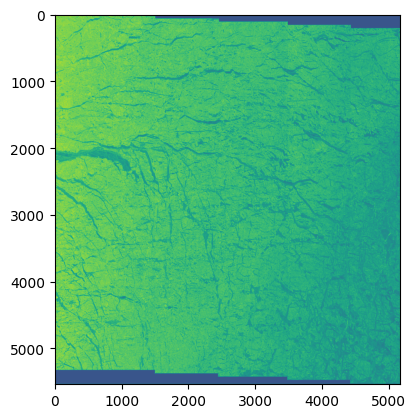

In [32]:
plt.imshow(d['nersc_sar_primary'])

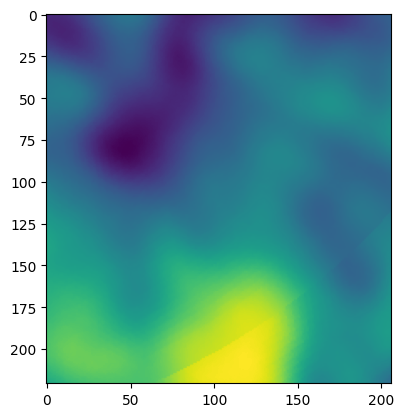

In [33]:
plt.imshow(d['btemp_6_9h'])

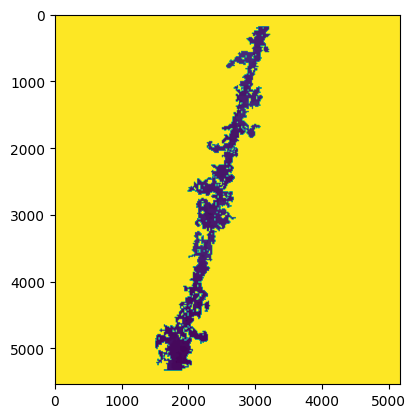

In [35]:
plt.imshow(d['sir_4000ms_seg'])

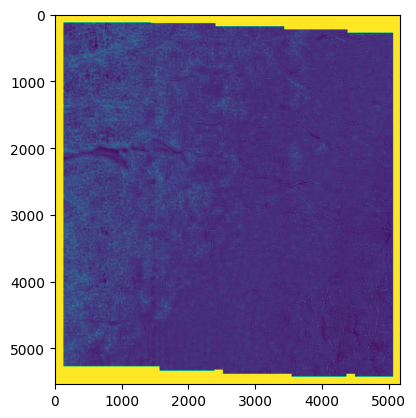

In [34]:
plt.imshow(d['sir_4000ms_reg'])

In [40]:
inf_x = np.load('tmp.npz')['inf_x']


In [49]:
np.isfinite(inf_x[0,5]).sum(), inf_x[0,0].size

(np.int64(7160816), 7160816)